# Chapter 7: Ensemble Methods and Random Forests

- **Bagging**: Building multiple models (typically of the same type) from different subsamples of the training dataset. <br>
<br>
- **Boosting**: Building multiple models (typically of the same type) each of which learns to fix the prediction errors of a prior model in the chain. <br>
<br>
- **Voting**: Building multiple models (typically of differing types) and simple statistics (like calculating the mean) are used to combine predictions. <br>
<br>
All methods can be used for classification or regression

In [269]:
# import libraries
import pandas as pd
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt

# set options for rendering plots
%matplotlib inline

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

import warnings
warnings.filterwarnings('ignore')

jtplot.reset()

We want diverse classifiers with uncorrelated errors so that we have an overall higher accuracy when we aggregate the predictors. <br>
- use a collection of very different algorithms as predictors
- same training algorithm, but train on different random subsets of the training set (bagging, pasting, etc.)

# Voting Classifiers

Train multiple classifiers on the same training set and aggregate the predictions via **Hard Voting** (take the most frequently predicted class among the predictors) or **Soft Voting** (use the predicted probabilities to give higher weights to more confident predictions)

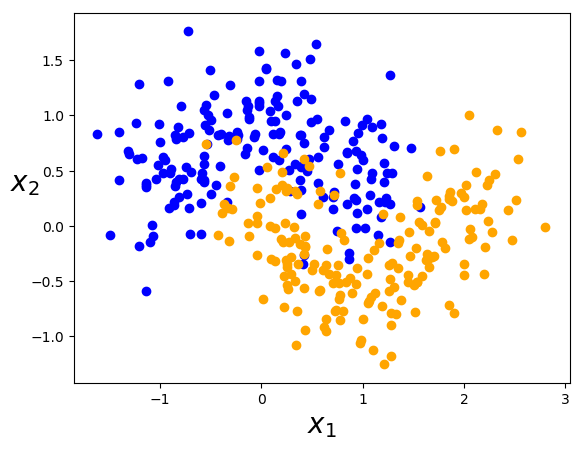

In [270]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise = 0.3, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.scatter(X_train[(y_train==0),0],X_train[(y_train==0),1], c = 'blue')
plt.scatter(X_train[(y_train==1),0],X_train[(y_train==1),1], c = 'orange')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plt.show();

In [209]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# classifiers
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

# hard voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train);

In [210]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred));

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [211]:
# classifiers
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42, probability = True) # set svm to have predict_proba method

# soft voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train);

In [212]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred));

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


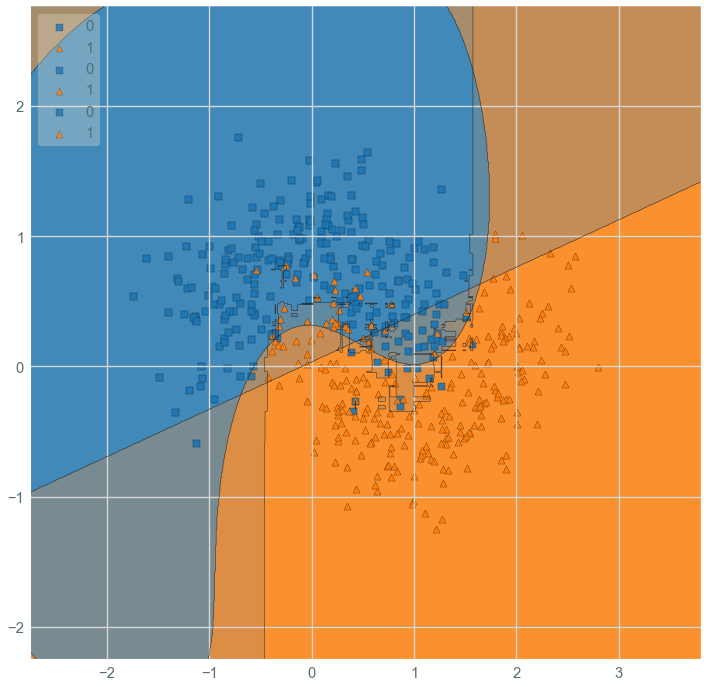

In [213]:
# overlapping decision boundaries for random forest, logistic regression,
# and svm classifiers
from mlxtend.plotting import plot_decision_regions
plt.figure(figsize = ((12, 12)))
plot_decision_regions(X, y, clf=rnd_clf, legend=2);
plot_decision_regions(X, y, clf=log_clf, legend=2);
plot_decision_regions(X, y, clf=svm_clf, legend=2);

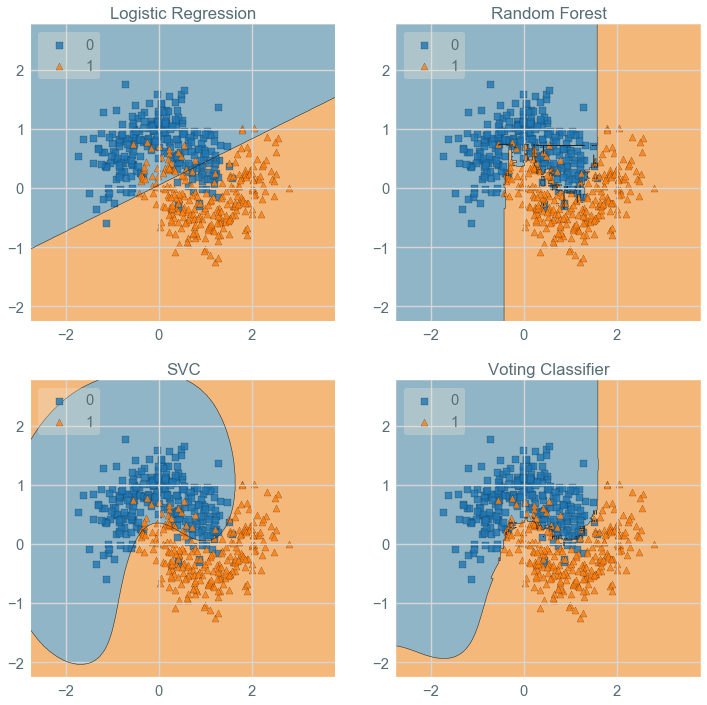

In [214]:
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(12,12))

labels = ['Logistic Regression', 'Random Forest', 'SVC', 'Voting Classifier']
for clf, lab, grd in zip([log_clf, rnd_clf, svm_clf, voting_clf],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)

plt.show();

# Bagging and Pasting

To get diverse predictors in our ensemble we can also train the predictors on different subsets of the training samples <br>
<br>
Bagging = Bootstrap aggregating, sample training instances with replacement. Generally preferred to pasting <br>
<br>
Pasting = sample training instances without replacement

## Bagging

We train many decision trees on random subsets of the training data, and then use soft voting to aggregate predictions

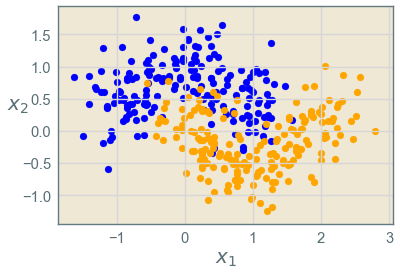

In [215]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise = 0.3, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.scatter(X_train[(y_train==0),0],X_train[(y_train==0),1], c = 'blue')
plt.scatter(X_train[(y_train==1),0],X_train[(y_train==1),1], c = 'orange')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plt.show();

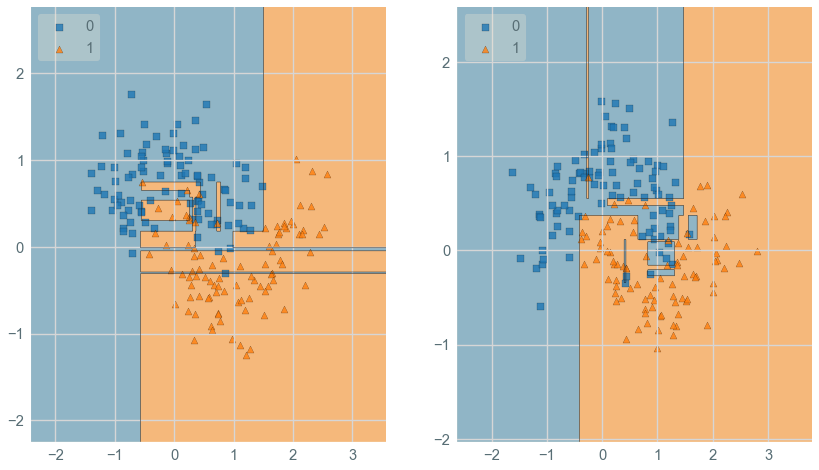

In [216]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Training two trees on random subsets of the training data
# n_estimators = 2
X_train_sub, X_train_sub2, y_train_sub, y_train_sub2 = train_test_split(X_train, y_train, 
                                                                    test_size = 0.5)

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_sub, y_train_sub)

tree_clf2 = DecisionTreeClassifier()
tree_clf2.fit(X_train_sub2, y_train_sub2)

plt.figure(figsize = ((14, 8)))
plt.subplot(1, 2, 1)
plot_decision_regions(X_train_sub, y_train_sub, clf=tree_clf, legend=2)
plt.subplot(1, 2, 2)
plot_decision_regions(X_train_sub2, y_train_sub2, clf=tree_clf2, legend=2);

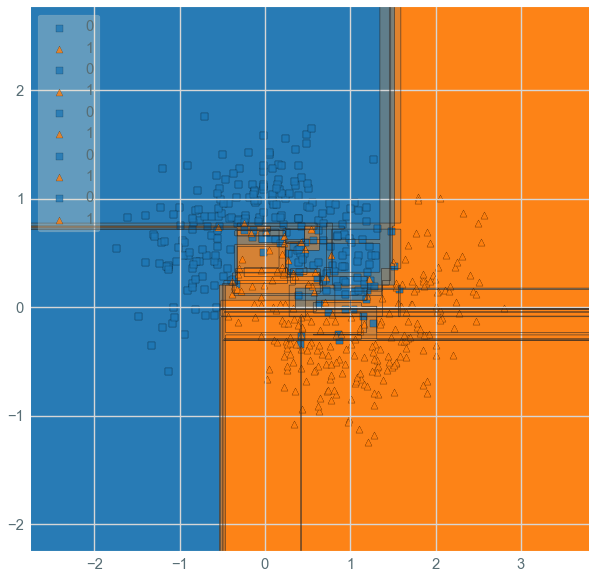

In [217]:
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,10))

# fit decision tree classifiers to randomly selected subsets of training data
rs = ShuffleSplit(n_splits=5, train_size=0.5, test_size=.25, random_state=0)
tree_clf = DecisionTreeClassifier()
for train_index, test_index in rs.split(X):
    model = clone(tree_clf)
    model.fit(X[train_index], y[train_index])
    plot_decision_regions(X=X, y=y, clf=model, legend=2)

plt.show();    

The overlapping decision regions show the aggregated predictions from the decision trees

In [236]:
from sklearn.ensemble import BaggingClassifier

# set max_samples for size of individual training subsets
# set bootstrap = false for pasting
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=100, 
    max_samples=50, bootstrap=True, n_jobs=-1, oob_score = True
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

# evaluate bagging classifier
# out of bag score evaluates the average predictions made by the 
# individual classifiers on their "out of bag" instances 
print("Out of bag accuracy: " + str(bag_clf.oob_score_))
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)));

Out of bag accuracy: 0.9146666666666666
Accuracy Score: 0.928


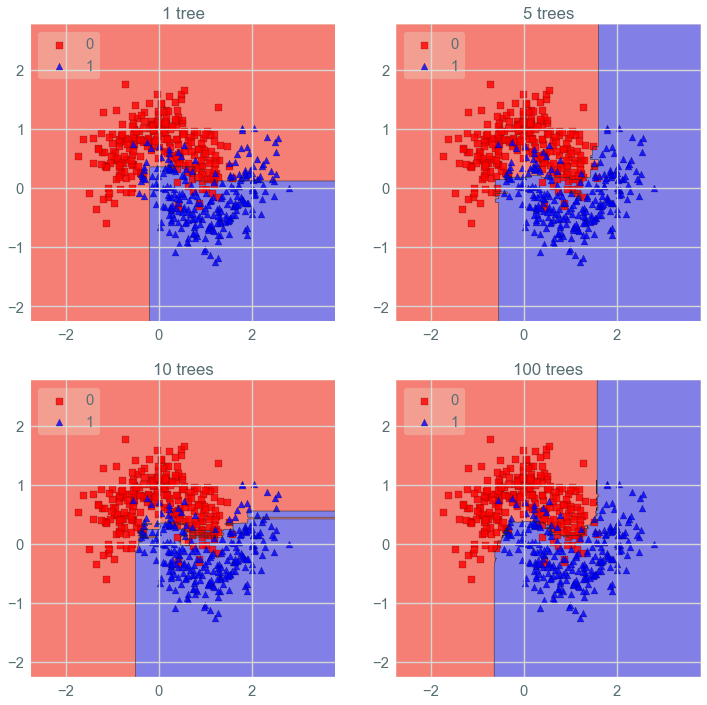

In [231]:
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(12,12))

bag1_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=1, max_samples=50, bootstrap=True, n_jobs=-1
)

bag2_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=5, max_samples=50, bootstrap=True, n_jobs=-1
)

bag3_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=10, max_samples=50, bootstrap=True, n_jobs=-1
)

bag4_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=100, max_samples=50, bootstrap=True, n_jobs=-1
)

labels = ['1 tree', '5 trees', '10 trees', '100 trees']
for clf, lab, grd in zip([bag1_clf, bag2_clf, bag3_clf, bag4_clf],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2, colors='red,blue')
    plt.title(lab)

plt.show();

You can also use samples of the features when training the predictors in a bagging classifier. Sampling both instances and features is called Random Patches, sampling only features is called Random Subspaces. 

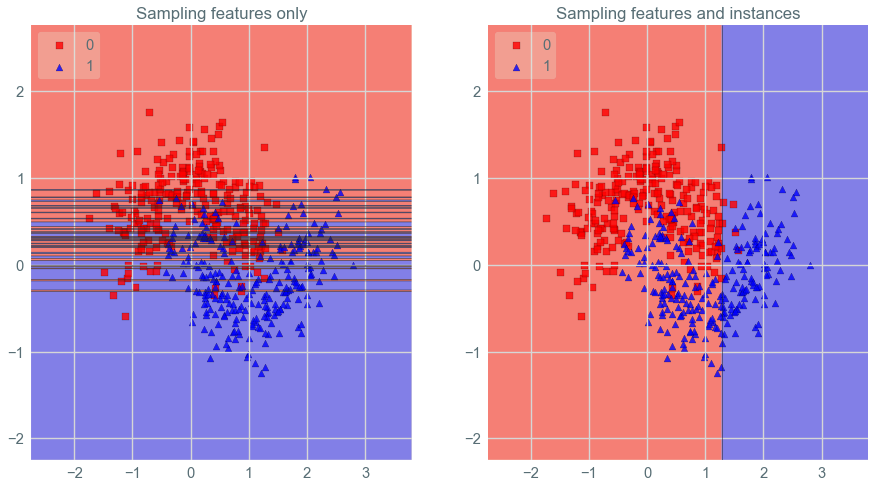

In [251]:
fig = plt.figure(figsize=(15, 8))

# uses all instances but subset of features
bag1_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth = 3, max_leaf_nodes=2), n_estimators=1, max_features = 1, bootstrap=True, n_jobs=-1
)

bag1_clf = bag_clf.fit(X_train, y_train)
plt.subplot(1, 2, 1)
plt.title("Sampling features only")
plot_decision_regions(X, y, clf = bag1_clf, legend = 2, colors = 'red,blue');

# uses subset of instances and subset of features
bag2_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth = 3, max_leaf_nodes=2), n_estimators=1, max_samples = 50, 
    max_features = 1, bootstrap=True, n_jobs=-1
)

bag2_clf = bag2_clf.fit(X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Sampling features and instances")
plot_decision_regions(X, y, clf = bag2_clf, legend = 2, colors = 'red,blue');

## Random Forests

Random forests is an ensemble of decision trees, trained via bagging. When growing trees, searches for best split among a **random** subset of the features. <br>
<br>
Greater diversity among the trees -> higher bias, lower variance (overall better model)

## Extra-Trees

Even more randomness by also using random thresholds for each feature rather than searching for the best possible threshold. Extra-trees are faster to train than random forests, hard to tell if it will improve over standard random forests.

In [259]:
from sklearn.ensemble import ExtraTreesClassifier

extree_clf = ExtraTreesClassifier()
extree_clf = extree_clf.fit(X_train, y_train)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(X_train, y_train)

print("Extra Trees Accuracy: " + str(accuracy_score(y_test, extree_clf.predict(X_test))))
print("Random Forest Accuracy: " + str(accuracy_score(y_test, rf_clf.predict(X_test))))

Extra Trees Accuracy: 0.856
Random Forest Accuracy: 0.888


# Boosting

Two main categories of boosting: AdaBoost (Adaptive boosting) and Gradient boosting. Boosting ensemble methods train predictors sequentially as opposed to training predictors in parallel and aggregating predictions.

## AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention
to the training instances that the predecessor underfitted. This results in new predictors
focusing more and more on the hard cases. This is the technique used by Ada‐
Boost. <br>
<br>
For example, to build an AdaBoost classifier, a first base classifier (such as a Decision
Tree) is trained and used to make predictions on the training set. The relative weight
of misclassified training instances is then increased. A second classifier is trained
using the updated weights and again it makes predictions on the training set, weights
are updated, and so on. <br>
<br>
Final Predictions are then made by weighting the individual predictors based on their overall accuracy

**Equation 7-1: Weighted error rate of the $j^\text{th}$ predictor**

$
r_j = \dfrac{\displaystyle \sum\limits_{\textstyle {i=1 \atop \hat{y}_j^{(i)} \ne y^{(i)}}}^{m}{w^{(i)}}}{\displaystyle \sum\limits_{i=1}^{m}{w^{(i)}}} \quad
\text{where }\hat{y}_j^{(i)}\text{ is the }j^{\text{th}}\text{ predictor's prediction for the }i^{\text{th}}\text{ instance.}
$

**Equation 7-2: Predictor weight**

$
\begin{split}
\alpha_j = \eta \log{\dfrac{1 - r_j}{r_j}}
\end{split}
$


**Equation 7-3: Weight update rule**

$
\begin{split}
& \text{ for } i = 1, 2, \dots, m \\
& w^{(i)} \leftarrow
\begin{cases}
w^{(i)} & \text{if }\hat{y_j}^{(i)} = y^{(i)}\\
w^{(i)} \exp(\alpha_j) & \text{if }\hat{y_j}^{(i)} \ne y^{(i)}
\end{cases}
\end{split}
$

**In the text page 194:**

Then all the instance weights are normalized (i.e., divided by $ \sum_{i=1}^{m}{w^{(i)}} $).


**Equation 7-4: AdaBoost predictions**

$
\hat{y}(\mathbf{x}) = \underset{k}{\operatorname{argmax}}{\sum\limits_{\scriptstyle j=1 \atop \scriptstyle \hat{y}_j(\mathbf{x}) = k}^{N}{\alpha_j}} \quad \text{where }N\text{ is the number of predictors.}
$


$\eta$ is the learning rate parameter

In [316]:
from sklearn.ensemble import AdaBoostClassifier

# SAMME = Stagewise additive modeling using a multiclass exponential loss function
# SAMME.R if base classifier has predict_proba method
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=100,
    algorithm="SAMME.R", 
    learning_rate=1.0
)

ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)));

Accuracy Score: 0.84


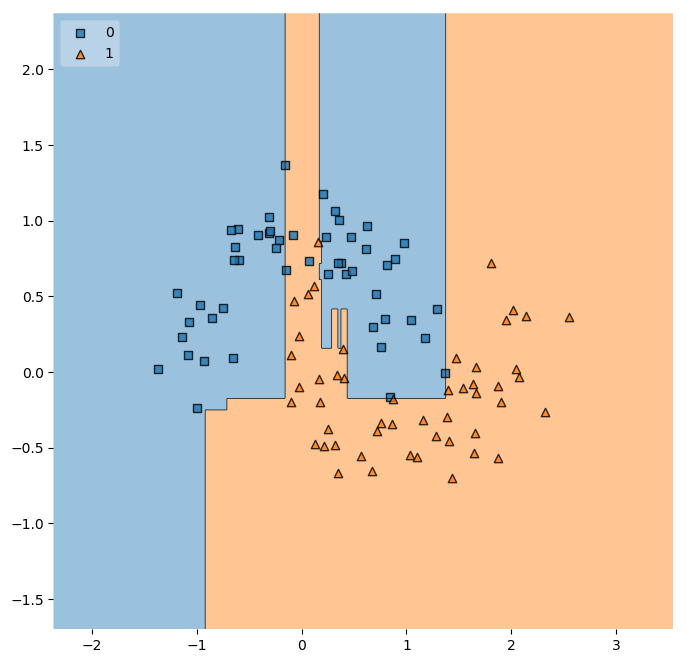

In [317]:
plt.figure(figsize = (8, 8))
plot_decision_regions(X, y, ada_clf, legend = 2);

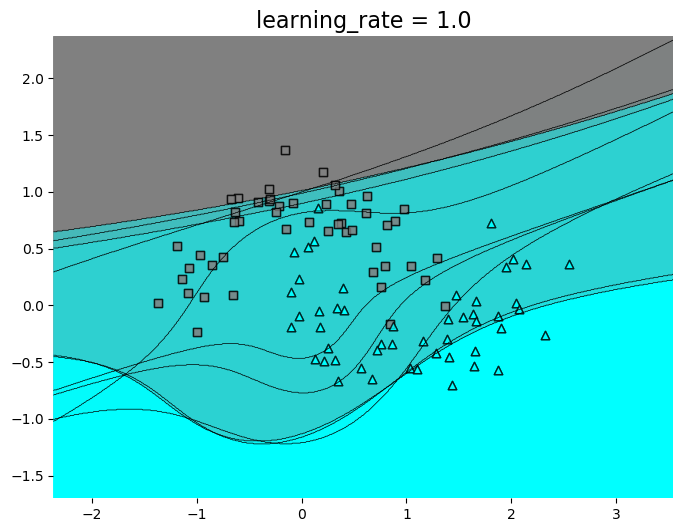

In [329]:
m = len(X_train)

plt.figure(figsize=(8, 6))
sample_weights = np.ones(m)

learning_rate = 1.0

for i in range(10):
    svm_clf = SVC(kernel="poly", degree = 3, random_state=42)
    svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = svm_clf.predict(X_train)
    sample_weights[y_pred != y_train] *= (1 + learning_rate)
    plot_decision_regions(X, y, svm_clf, legend = 0, colors='gray,cyan')
    
plt.title("learning_rate = 1.0", fontsize=16)
plt.show();

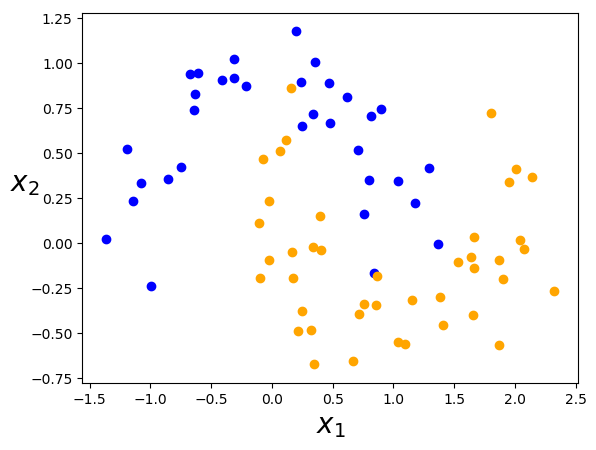

<Figure size 400x400 with 0 Axes>

In [325]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise = 0.2, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.scatter(X_train[(y_train==0),0],X_train[(y_train==0),1], c = 'blue')
plt.scatter(X_train[(y_train==1),0],X_train[(y_train==1),1], c = 'orange')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.figure(figsize=(4,4))
plt.show();

Predictor: 1 Sample weights 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
Predictor: 2 Sample weights 
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Predictor: 3 Sample weights 
[2. 4. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2.]
Predictor: 4 Sample weights 
[2. 2. 4. 2. 2. 2. 4. 2. 2. 4. 2. 4. 2. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2. 2.
 2.]


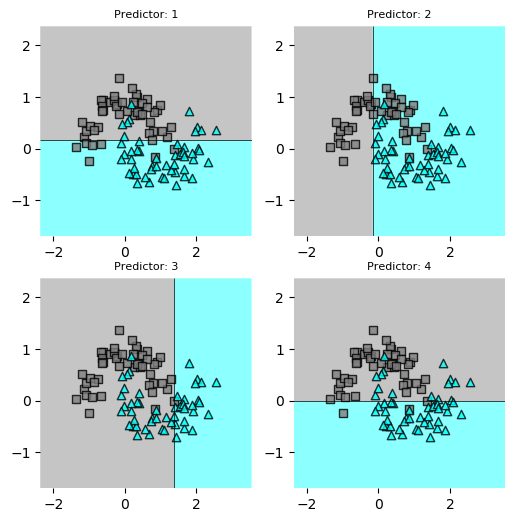

In [321]:
m = len(X_train)

plt.figure(figsize=(6, 6))
sample_weights = np.ones(m)

learning_rate = 1.0

for i in range(4):
    print("Predictor: " + str(i+1) + " Sample weights ")
    print(sample_weights[y_pred != y_train])
    tree_clf = DecisionTreeClassifier(max_depth=1)
    tree_clf.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = tree_clf.predict(X_train)
    sample_weights[y_pred != y_train] *= (1 + learning_rate)
    plt.subplot(2, 2, i+1)
    plot_decision_regions(X, y, tree_clf, legend = 0, colors='gray,cyan')
    plt.title("Predictor: " + str(i+1), fontsize=8)
    
plt.show();

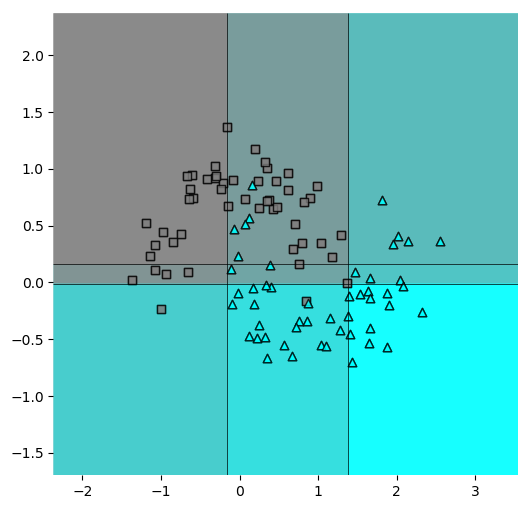

In [322]:
m = len(X_train)

plt.figure(figsize=(6, 6))
sample_weights = np.ones(m)

learning_rate = 1.0

for i in range(4):
    tree_clf = DecisionTreeClassifier(max_depth=1)
    tree_clf.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = tree_clf.predict(X_train)
    sample_weights[y_pred != y_train] *= (1 + learning_rate)
    plot_decision_regions(X, y, tree_clf, legend = 0, colors='gray,cyan')
    
plt.show();

Accuracy Score: 0.84


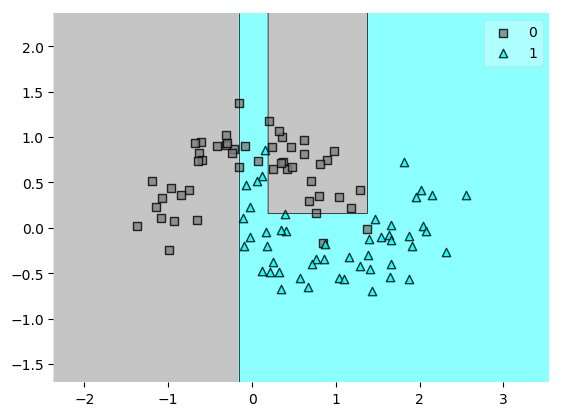

In [323]:
from sklearn.ensemble import AdaBoostClassifier

# SAMME = Stagewise additive modeling using a multiclass exponential loss function
# SAMME.R if base classifier has predict_proba method
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=4,
    algorithm="SAMME.R", 
    learning_rate=1.0
)

ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
plot_decision_regions(X, y, ada_clf, colors = 'gray,cyan');

## Gradient Boosting

Instead of adding predictors sequentially and updating instance weights, gradient boosting combines predictors by training sequentially on the residual errors 

In [387]:
from sklearn import datasets

# The ten features are standard independent Gaussian and the target y is defined by:
# y[i] = 1 if np.sum(X[i] ** 2) > 9.34 else -1
X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)
X = X.astype(np.float32)

# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

In [391]:
# binary classification example
from sklearn.ensemble import GradientBoostingClassifier
original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 
                   'random_state': 2,
                   'min_samples_split': 5}
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)));

Accuracy Score: 0.873


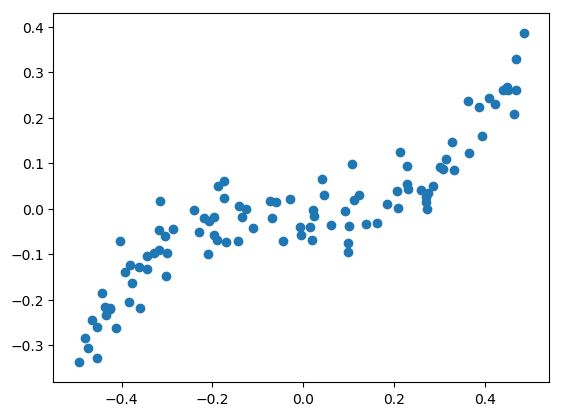

In [392]:
# regression example
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**3 + 0.05 * np.random.randn(100)
plt.scatter(X, y);

In [393]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3);

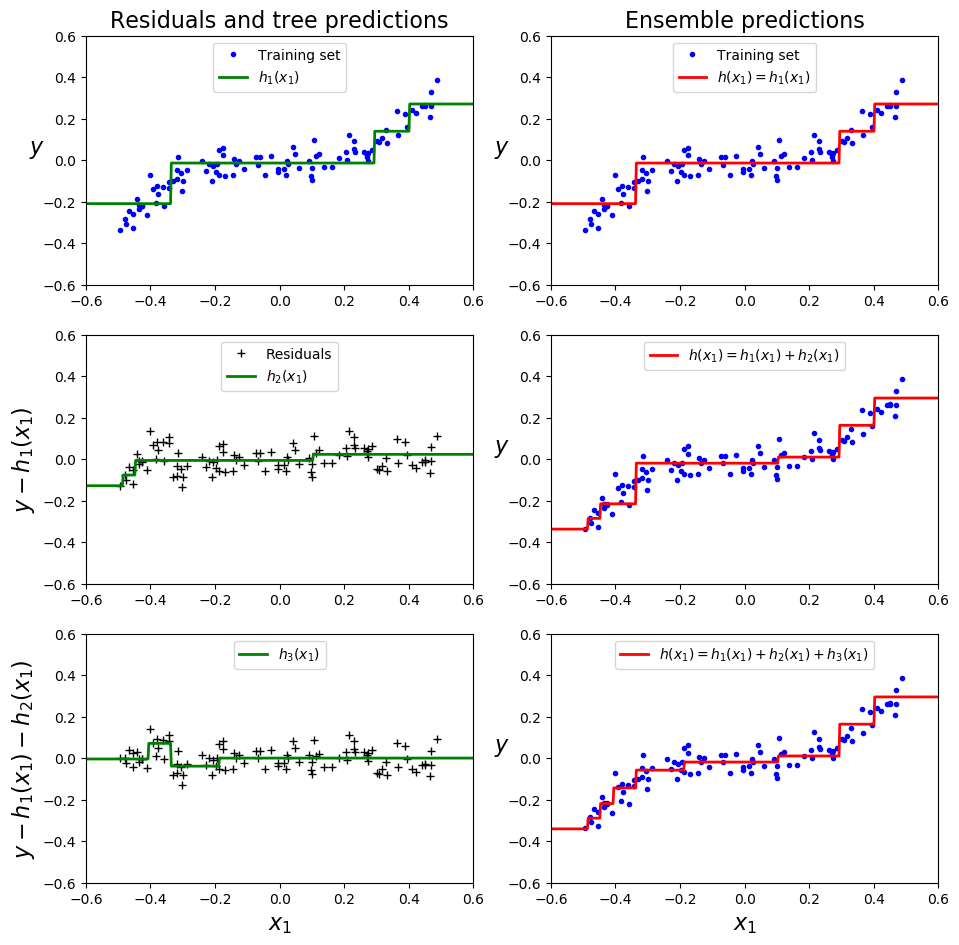

In [394]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=10)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.6, 0.6, -0.6, 0.6], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.6, 0.6, -0.6, 0.6], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.6, 0.6, -0.6, 0.6], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.6, 0.6, -0.6, 0.6], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.6, 0.6, -0.6, 0.6], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.6, 0.6, -0.6, 0.6], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0);

In [395]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# regression example
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**3 + 0.05 * np.random.randn(100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gb_clf = gbrt.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.004438114523285744

Learning rate - $\eta$ can be lowered as a regularization technique called *shrinkage*, but this generally requires more trees in the ensemble. <br>
<br>
The subsample parameter can be set < 1 to train each tree on a random subset of training instances. <br><br> This is called **Stochastic Gradient Boosting** <br> <br>
Early Stopping - used to find optimal number of trees where validation error stops improving

In [401]:
# early stopping, set warm start = true
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
    if error_going_up == 5:
        print("Optimal trees: " + str(n_estimators))
        break # early stopping;

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=2, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=4, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=6, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=7, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=8, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=9, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=11, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=12, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=13, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=14, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=15, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=16, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=17, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=18, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=19, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=20, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=21, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=22, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=23, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=24, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=25, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=26, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=27, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=28, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=29, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=30, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=31, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=32, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=33, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=34, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=35, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=36, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=37, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=38, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

Optimal trees: 38


# Stacking